# Modeling Pipeline

In [1]:
import sys
sys.path.insert(0, '..')

import pandas as pd
from src import Task, TaskGroup, Flag, AbstractTask, AbstractFlag, Pipeline, BaseFlag, plotMatrix, plotReport
from src import executors as ex

import warnings
warnings.filterwarnings("ignore")


In [2]:
dataPath = r"..\data\csv" + "\\"
picklePath = r"..\pickle_objects\modeling_pipeline" + "\\"
plotPath = r"..\plots\modeling_pipeline" + "\\"
tablePath = r"..\tables\modeling_pipeline" + "\\"

In [3]:
file = r"SkyTag\SkyTag_(nearby).csv"
data = pd.read_csv(dataPath + file, encoding = 'cp1252')

In [4]:
flags = []

flag_preProcessing = Flag("Pre Processing")
flag_dummy =  Flag("Dummy Processing")
flag_modeling =  Flag("Modeling")

flags.extend([flag_preProcessing,flag_dummy, flag_modeling])

In [5]:
modelingPipeline = TaskGroup('Modeling Pipeline', idempotency=True)

generalPreProcessing = TaskGroup('Pre Processing', 10, idempotency=True, flags = flag_preProcessing)

columns = ['Time', 'Source', 'Channel', 'Length Packet', 'Length Header', 'AD Type', 'Company ID', 'MS Data', 'UUID', 'Service Data', 'PDU']

task_orderColumns = Task("Select and order columns", priority=10, 
                            executor = ex.keepColumns( columns= columns))


taskGroup_Company_and_UUID = TaskGroup('Company ID and UUID', priority=20, idempotency=True)


task_fillNa_Company = Task("Fill Company ID with None", priority=10,
                              executor = ex.fillNa(fillValue="None",
                                                   columns=['Company ID']
                                                   )
                              )

task_fillNa_UUID = Task("Fill UUID with None", priority=20,
                           executor = ex.fillNa(fillValue="None",
                                                columns=['UUID']
                                                )
                           )


companies = {'Apple, Inc.': 'Apple', 'Tile, Inc.': 'Tile', 'Samsung Electronics Co., Ltd.': 'Samsung', 'Apple Inc.': 'Apple'}

task_ReplaceCompanyID = Task("Replace Company IDs", priority = 30, executor = ex.StringReplace(column = 'Company ID', replace = companies))
task_ReplaceCompanyUUID = Task("Replace Company UUIDs", priority = 40, executor = ex.StringReplace(column = 'UUID', replace = companies))


taskGroup_Company_and_UUID.addAll([task_fillNa_Company, task_fillNa_UUID, task_ReplaceCompanyID, task_ReplaceCompanyUUID
                                   ])

taskGroup_MS_Data = TaskGroup("MS Data Processing", priority=30, idempotency=True)

task_convert_fillNa_MSData = Task("Fill MS Data with empty String", priority=10, 
                                     executor = ex.fillNa(fillValue="", 
                                                          columns=['MS Data']
                                                          )
                                     )


task_length_MS_Data = Task("Length of MS Data", priority = 20, 
                              executor = ex.convertToBitLength('MS Data', newColumn='Length MS Data')
                              )

task_Continuity_Type = Task("Continuity Type", priority=30, 
                               executor = ex.extractAppleDataType(  companyColumn="Company ID", 
                                                               company = 'Apple', 
                                                               dataColumn= 'MS Data', 
                                                               typeColumn= 'Continuity Type', 
                                                               noneValue= "None")
                               )

task_drop_MS_Data = Task("Drop MS Data Column", priority=40, 
                            executor = ex.dropColumns(columns=['MS Data'])
                            )

taskGroup_MS_Data.addAll([task_convert_fillNa_MSData, task_length_MS_Data, task_Continuity_Type, task_drop_MS_Data])


taskGroup_ServiceData = TaskGroup("Service Data Processing", priority=40, idempotency=True)

task_convert_fillNa_ServiceData = Task("Fill Service Data with empty String", priority=10,
                                     executor = ex.fillNa(fillValue="",
                                                          columns=['Service Data']
                                                          )
                                     )

task_length_ServiceData= Task("Length of Service Data", priority = 20,
                              executor = ex.convertToBitLength(column = 'Service Data', newColumn='Length Service Data')
                              )

task_Samsung_Type= Task("Samsung Type", priority=30,
                           executor = ex.extractSamsungDataType(companyColumn="UUID",
                                                                company = 'Samsung',
                                                                dataColumn= 'Service Data',
                                                                typeColumn= 'SmartTag Type',
                                                                noneValue= "None")
                           )

task_drop_Service_Data = Task("Drop Service Data Column", priority=40,
                            executor = ex.dropColumns(columns=['Service Data'])
                            )


taskGroup_ServiceData.addAll([task_convert_fillNa_ServiceData, task_length_ServiceData, task_Samsung_Type, task_drop_Service_Data])





task_fillNa_Numeric = Task("Fill Numeric NA with 0", priority=50, 
                              executor = ex.fillNa(fillValue="None", 
                                                   columns = ['Length Packet', 'Length Header']
                                                   )
                              )

task_fillNa_String = Task("Fill String NA with None", priority=60, executor = ex.fillNa(fillValue="None"))



task_toDatetime = Task("Datetime conversion", priority = 70, 
                          executor = ex.toDateTime(column = "Time", 
                                                   unit = 's'
                                                   )
                          )



task_clean_PDU = Task("Clean PDU", priority=80, executor=ex.cleanPDU(column = 'PDU'))



task_orderDataFrame =  Task("Order DataFrame",  priority=90,
                               executor= ex.orderDataFrame(column = "Time", 
                                                           ascending=True
                                                           )
                               )

task_convertObjectToString= Task("Convert object type to string", priority=100, executor=ex.convertObjectToString())


generalPreProcessing.addAll([task_orderColumns, taskGroup_Company_and_UUID, task_toDatetime, task_convertObjectToString, task_fillNa_Numeric, task_fillNa_String, task_orderDataFrame, taskGroup_MS_Data, taskGroup_ServiceData, task_clean_PDU])
modelingPipeline.add(generalPreProcessing)

modelingPipeline.print(flags=True, priority=True)

Modeling Pipeline
	10 Pre Processing: Pre Processing
		10 Select and order columns
		20 Company ID and UUID
			10 Fill Company ID with None
			20 Fill UUID with None
			30 Replace Company IDs
			40 Replace Company UUIDs
		30 MS Data Processing
			10 Fill MS Data with empty String
			20 Length of MS Data
			30 Continuity Type
			40 Drop MS Data Column
		40 Service Data Processing
			10 Fill Service Data with empty String
			20 Length of Service Data
			30 Samsung Type
			40 Drop Service Data Column
		50 Fill Numeric NA with 0
		60 Fill String NA with None
		70 Datetime conversion
		80 Clean PDU
		90 Order DataFrame
		100 Convert object type to string


In [6]:
DummmyProcessing = TaskGroup("Dummy Processing", priority=20, idempotency=True, flags = flag_dummy)



task_DummiesChannel =  Task("Dummies Channel",  priority=10,
                               executor= ex.createDummies( column = 'Channel', 
                                                           labels = [37, 38, 39], 
                                                           prefix = "CH", 
                                                           splitting = False, 
                                                           dropColumn= True, 
                                                           NoneValue= 'None')
                               )

AD_Types = [ 'Manufacturer Specific',
             'Flags',
             'Tx Power Level',
             'Service Data - 16 bit UUID',
             '16-bit Service Class UUIDs',
             '16-bit Service Class UUIDs (incomplete)'
            ]

task_DummiesAdType= Task("Dummies AD Type", priority=20,
                            executor = ex.createDummies(column = 'AD Type', 
                                                        labels = AD_Types, prefix='AD', 
                                                        splitting = True, 
                                                        OtherColumn = True, 
                                                        dropColumn=True, 
                                                        NoneValue= 'None')
                            )


task_DummiesCompany = Task("Dummies Company",   priority=30,
                              executor = ex.createDummies(column = 'Company ID', 
                                                          labels = ['Apple'], 
                                                          prefix = "COMP",
                                                          splitting = False, 
                                                          OtherColumn = True, 
                                                          dropColumn= True, 
                                                          NoneValue= 'None')
                              )

task_DummiesUUID = Task("Dummies UUID",   priority=40,
                            executor = ex.createDummies(column = 'UUID',
                                                          labels = ['Samsung', 'Tile'],
                                                          prefix = "UUID",
                                                          splitting = True,
                                                          OtherColumn = True,
                                                          dropColumn= True,
                                                          NoneValue= 'None')
                              )


InfoTypes = ['ADV_IND', 
             'ADV_NONCONN_IND', 
             'ADV_SCAN_IND',
             ]


task_DummiesInfo =  Task("Dummies PDU Type", priority=50,
                            executor = ex.createDummies(column = 'PDU', 
                                                        labels = InfoTypes,
                                                        prefix='PDU',
                                                        splitting = False, 
                                                        OtherColumn = True, 
                                                        dropColumn=True, 
                                                        NoneValue= 'None')
                            )


continuityTypes = ['07', '12']

task_DummiesContinuity =  Task("Dummies Continuity Type", priority=60,
                                    executor = ex.createDummies(column = 'Continuity Type', 
                                                                labels = continuityTypes, 
                                                                prefix='CT', 
                                                                splitting = False, 
                                                                OtherColumn = True, 
                                                                dropColumn=False, 
                                                                NoneValue= 'None')
                                 )


SmartTagTypes = ['3', '5']

task_DummiesSmartTagType=  Task("Dummies SmartTag Type", priority=70,
                                  executor = ex.createDummies(column = 'SmartTag Type',
                                                              labels = SmartTagTypes,
                                                              prefix='ST',
                                                              splitting = False,
                                                              OtherColumn = True,
                                                              dropColumn=True,
                                                              NoneValue= 'None')
                                  )


DummmyProcessing.addAll([task_DummiesCompany, task_DummiesUUID, task_DummiesChannel, task_DummiesAdType, task_DummiesInfo, task_DummiesContinuity, task_DummiesSmartTagType])

modelingPipeline.add(DummmyProcessing)
modelingPipeline.print(flags=True, priority=True)

Modeling Pipeline
	10 Pre Processing: Pre Processing
		10 Select and order columns
		20 Company ID and UUID
			10 Fill Company ID with None
			20 Fill UUID with None
			30 Replace Company IDs
			40 Replace Company UUIDs
		30 MS Data Processing
			10 Fill MS Data with empty String
			20 Length of MS Data
			30 Continuity Type
			40 Drop MS Data Column
		40 Service Data Processing
			10 Fill Service Data with empty String
			20 Length of Service Data
			30 Samsung Type
			40 Drop Service Data Column
		50 Fill Numeric NA with 0
		60 Fill String NA with None
		70 Datetime conversion
		80 Clean PDU
		90 Order DataFrame
		100 Convert object type to string
	20 Dummy Processing: Dummy Processing
		10 Dummies Channel
		20 Dummies AD Type
		30 Dummies Company
		40 Dummies UUID
		50 Dummies PDU Type
		60 Dummies Continuity Type
		70 Dummies SmartTag Type


In [7]:
taskGroup_Modeling = TaskGroup("Modeling", priority=60, idempotency=True, flags = flag_modeling)

flag_dropColumns = Flag("Drop Columns", parents=flag_modeling)
task_dropColumns = Task("Drop Columns", priority=20, executor = ex.dropColumns(columns = ['Source', 'Time']), flags = flag_dropColumns)

flag_rateModeling = Flag("Rate Modeling", parents=flag_modeling)
task_rateModeling =Task("Rate Modeling", priority=10, executor = ex.modelRate(source='Source', time='Time', labelColumn='Label', seconds=10), flags = flag_rateModeling)


task_dropColumns_Continuity =  Task("Drop Column Continuity", priority=0, executor = ex.dropColumns(columns = ['Continuity Type']))

flags.extend([flag_rateModeling, flag_dropColumns])

taskGroup_Modeling.addAll([task_dropColumns, task_dropColumns_Continuity, task_rateModeling])

modelingPipeline.add(taskGroup_Modeling)
modelingPipeline.print(flags=True, priority=True)

Modeling Pipeline
	10 Pre Processing: Pre Processing
		10 Select and order columns
		20 Company ID and UUID
			10 Fill Company ID with None
			20 Fill UUID with None
			30 Replace Company IDs
			40 Replace Company UUIDs
		30 MS Data Processing
			10 Fill MS Data with empty String
			20 Length of MS Data
			30 Continuity Type
			40 Drop MS Data Column
		40 Service Data Processing
			10 Fill Service Data with empty String
			20 Length of Service Data
			30 Samsung Type
			40 Drop Service Data Column
		50 Fill Numeric NA with 0
		60 Fill String NA with None
		70 Datetime conversion
		80 Clean PDU
		90 Order DataFrame
		100 Convert object type to string
	20 Dummy Processing: Dummy Processing
		10 Dummies Channel
		20 Dummies AD Type
		30 Dummies Company
		40 Dummies UUID
		50 Dummies PDU Type
		60 Dummies Continuity Type
		70 Dummies SmartTag Type
	60 Modeling: Modeling
		0 Drop Column Continuity
		10 Rate Modeling: Rate Modeling
		20 Drop Columns: Drop Columns


In [8]:
temp = modelingPipeline.process(data.copy(deep=True), flag = Flag("Run", parents = [flag_preProcessing, flag_dummy, flag_modeling, flag_dropColumns]))
temp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 645973 entries, 0 to 645972
Data columns (total 29 columns):
 #   Column                                      Non-Null Count   Dtype
---  ------                                      --------------   -----
 0   Length Packet                               645973 non-null  int64
 1   Length Header                               645973 non-null  int64
 2   Length MS Data                              645973 non-null  int32
 3   Length Service Data                         645973 non-null  int32
 4   CH 37                                       645973 non-null  int32
 5   CH 38                                       645973 non-null  int32
 6   CH 39                                       645973 non-null  int32
 7   AD Manufacturer Specific                    645973 non-null  int32
 8   AD Flags                                    645973 non-null  int32
 9   AD Tx Power Level                           645973 non-null  int32
 10  AD Service Data - 16 bit 

In [9]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.neural_network import MLPClassifier
from copy import deepcopy

def filesToDataFrame(filesDict: dict[str:str], config: AbstractTask, filePath: str = dataPath,  shuffle:bool = False) -> pd.DataFrame:
    dataset = pd.DataFrame()

    for f in filesDict:
        new_dataset = Pipeline().setPath(filePath + f).setTask(config).loadData().run(flag=filesDict[f])
        dataset = pd.concat([dataset, new_dataset])

    if shuffle:
        dataset = dataset.sample(frac = 1, random_state=1)

    dataset.reset_index(drop = True, inplace = True)

    return dataset

def semiSupervisedLearning(dataset: pd.DataFrame, threshold: float, labelColumn:str = 'Label',
                           model =  MLPClassifier(max_iter = 200, verbose = False, random_state = 1, tol = 0.00001, early_stopping = True), 
                           scaler = MinMaxScaler()
                           ):
    
    Y = dataset[labelColumn]
    X = dataset.drop([labelColumn], axis = 1)
    
    scalerSelfTrain = scaler
    X = scalerSelfTrain.fit_transform(X)
    
    selfTrainer = SelfTrainingClassifier(model, threshold=threshold, max_iter=5, verbose=True)
    selfTrainer.fit(X, Y)
    
    return selfTrainer, scalerSelfTrain

def evaluateModel(model, scaler, dataset: pd.DataFrame, name:str, path_plot:str = plotPath, path_table:str = tablePath, labelColumn: str = 'Label'):
    Y = dataset[labelColumn]
    X = dataset.drop([labelColumn], axis = 1)
    labels = sorted(list(Y.unique()))
    
    X = scaler.transform(X)
    y_pred = model.predict(X)
    
    print("\n")
    plotReport(Y, y_pred, labels, name = name, savePath=path_table)
    plotMatrix(Y, y_pred, labels, name = name, savePath=path_plot, dpi=100)


def nearbyTrackerConfigFactory(BaseConfig: TaskGroup, firstDevice: str, secondDevice: str, parentFlags:list[AbstractFlag], priority: int = 30, 
                               selection: slice = slice(0), sourceColumn: str = 'Source', labelColumn: str = 'Label'):
  
    label_Traker_nearby_Flag = Flag(name = "Label nearby Tracker Flag", parents = parentFlags)
    label_Unknown_Flag = Flag("Unknown Label Flag", parents = parentFlags)

    taskGroup_Labeling = TaskGroup("Labeling", priority=priority, idempotency=True)

    task_Label_Unknown = Task("Label Unknown", executor = ex.labeling(label = -1,  labelColumn = labelColumn), flags=label_Unknown_Flag,)

    task_Label_Tracker_nearby = Task("Label nearby Tracker" ,
                                        executor = ex.labelMultipleDevices(firstDevice = firstDevice, secondDevice = secondDevice, selection = selection, source = sourceColumn, labelColumn = labelColumn)
                                        ,flags = label_Traker_nearby_Flag)

    taskGroup_Labeling.addAll([task_Label_Unknown, task_Label_Tracker_nearby])
    config = BaseConfig.copy().add(taskGroup_Labeling)

    return config, label_Traker_nearby_Flag, label_Unknown_Flag

def nearbyTrackerTaskFactory(labeledFiles: list[str], unlabeledFiles:list[str], evaluationFiles:list[str], BaseConfig:TaskGroup, firstDevice:str, 
                             secondDevice:str, priority:int = 30, flags: AbstractFlag = BaseFlag(), selection: slice = slice(0), sourceColumn: str = 'Source', 
                             labelColumn: str = 'Label', dropColumns:list[str] =None, suffix = '', parentFlags: list[AbstractFlag] =None, 
                             threshold:float = 0.95) -> Task:
    if parentFlags is None:
        parentFlags = [flag_modeling, flag_dummy, flag_preProcessing, flag_dropColumns]
    if dropColumns is None:
        dropColumns = ['Time', 'Source', 'Continuity Type']
        
    NearbyTrackerConfig, label_Traker_nearby_Flag, label_Unknown_Flag = nearbyTrackerConfigFactory(BaseConfig, firstDevice, secondDevice, parentFlags, priority, selection, sourceColumn, labelColumn)

    files_training = {f: label_Traker_nearby_Flag for f in labeledFiles}
    files_training.update({f: label_Unknown_Flag for f in unlabeledFiles})
    
    files_evaluation = {f: label_Traker_nearby_Flag for f in evaluationFiles}

    training_data = filesToDataFrame(files_training, config = NearbyTrackerConfig, shuffle = True)
    evaluation_data = filesToDataFrame(files_evaluation, config = NearbyTrackerConfig, shuffle = True)
    
    fitted_model, fitted_scaler = semiSupervisedLearning(training_data, threshold = threshold)
    
    title = "Label " + firstDevice + " and " + secondDevice + " " + suffix
    title = title.strip()
    
    evaluateModel(deepcopy(fitted_model), deepcopy(fitted_scaler), evaluation_data, name= title)
    
    return Task(title, flags = flags,  executor= ex.autoLabel(classifier=deepcopy(fitted_model), scaler=deepcopy(fitted_scaler), dropColumns=dropColumns, labelColumn = labelColumn))

In [10]:
NearbyTrackerConfig = modelingPipeline.copy()
NearbyTrackerConfig.print(priority =True, flags = True)

Modeling Pipeline
	10 Pre Processing: Pre Processing
		10 Select and order columns
		20 Company ID and UUID
			10 Fill Company ID with None
			20 Fill UUID with None
			30 Replace Company IDs
			40 Replace Company UUIDs
		30 MS Data Processing
			10 Fill MS Data with empty String
			20 Length of MS Data
			30 Continuity Type
			40 Drop MS Data Column
		40 Service Data Processing
			10 Fill Service Data with empty String
			20 Length of Service Data
			30 Samsung Type
			40 Drop Service Data Column
		50 Fill Numeric NA with 0
		60 Fill String NA with None
		70 Datetime conversion
		80 Clean PDU
		90 Order DataFrame
		100 Convert object type to string
	20 Dummy Processing: Dummy Processing
		10 Dummies Channel
		20 Dummies AD Type
		30 Dummies Company
		40 Dummies UUID
		50 Dummies PDU Type
		60 Dummies Continuity Type
		70 Dummies SmartTag Type
	60 Modeling: Modeling
		0 Drop Column Continuity
		10 Rate Modeling: Rate Modeling
		20 Drop Columns: Drop Columns


In [11]:
label_FindMy_Tracker = "FindMy Tracker"
label_iDevice = "iDevice"
label_SmartTag = 'SmartTag'
label_Tile = 'Tile'
label_other_Device = 'other Device'
label_AirPod = 'AirPod'
label_Unknown = -1

labels_devices = [label_FindMy_Tracker, label_iDevice, label_SmartTag, label_Tile, label_other_Device, label_AirPod, label_Unknown]

labels_trackers = [label_FindMy_Tracker, label_SmartTag, label_Tile]
labels_iDevices = [label_iDevice]

In [12]:
flag_labeling = Flag("Labeling")

flag_label_auto = Flag("Labeling auto", parents=flag_labeling)
flag_label_FindMy_Tracker_and_iDevice = Flag(f"Label {label_FindMy_Tracker} and {label_iDevice}", parents=flag_label_auto)
flag_label_AirPod_and_iDevice = Flag(f"Label {label_AirPod} and {label_iDevice}", parents=flag_label_auto)
flag_label_Tile_and_iDevice = Flag(f"Label {label_Tile} and {label_iDevice}", parents=flag_label_auto)
flag_label_SmartTag_and_Other = Flag(f"Label {label_SmartTag} and Other", parents=flag_label_auto)

flag_label_manual = Flag("Labeling manual", parents=flag_labeling)

flag_label_FindMy_Tracker = Flag(f"Label {label_FindMy_Tracker}", parents=flag_label_manual)
flag_label_iDevice = Flag(f"Label {label_iDevice}", parents=flag_label_manual)
flag_label_SmartTag = Flag(f"Label {label_SmartTag}", parents=flag_label_manual)
flag_label_Tile = Flag(f"Label {label_Tile}", parents=flag_label_manual)
flag_label_Other = Flag(f"Label {label_other_Device}", parents=flag_label_manual)
flag_label_AirPod = Flag(f"Label {label_AirPod}", parents=flag_label_manual)
flag_label_Unknown = Flag("Label Unknown", parents=flag_label_manual)

flag_states = Flag("States")

flag_states_iDevices = Flag("States iDevices", parents=flag_states)
flag_states_Continuity = Flag("States Continuity", parents=flag_states_iDevices)


flag_states_Tracker = Flag("States Tracker", parents=flag_states)
flag_state_lost = Flag("State lost", parents=flag_states_Tracker)
flag_state_unpaired = Flag("State unpaired", parents=flag_states_Tracker)
flag_state_nearby = Flag("State nearby", parents=flag_states_Tracker)

flags.extend([flag_labeling])

flags.extend([flag_label_manual, flag_label_FindMy_Tracker, flag_label_iDevice, flag_label_SmartTag, flag_label_Tile, flag_label_Other, flag_label_Unknown])

flags.extend([flag_label_auto, flag_label_FindMy_Tracker_and_iDevice, flag_label_Tile_and_iDevice, flag_label_SmartTag_and_Other])

flags.extend([flag_states, flag_states_iDevices, flag_states_Continuity, flag_states_Tracker, flag_state_lost, flag_state_unpaired, flag_state_nearby])

In [13]:
label_flag_lut = {  label_FindMy_Tracker: flag_label_FindMy_Tracker,
                    label_iDevice: flag_label_iDevice,
                    label_SmartTag: flag_label_SmartTag,
                    label_Tile: flag_label_Tile,
                    label_other_Device: flag_label_Other,
                    label_AirPod: flag_label_AirPod,
                    label_Unknown: flag_label_Unknown
                }

In [14]:
taskGroup_Labeling = TaskGroup("Labeling", priority=30, idempotency=True, flags = flag_labeling)
taskGroup_Labeling_auto = TaskGroup("Labeling auto", priority=10, idempotency=True, flags = flag_label_auto)
taskGroup_Labeling_manual = TaskGroup("Labeling manual", priority=20, idempotency=True, flags = flag_label_manual)


Classification Report - Label FindMy Tracker and iDevice
                precision    recall  f1-score   support

FindMy Tracker     1.0000    0.9985    0.9993      3382
       iDevice     0.9998    1.0000    0.9999     31129

      accuracy                         0.9999     34511
     macro avg     0.9999    0.9993    0.9996     34511
  weighted avg     0.9999    0.9999    0.9999     34511


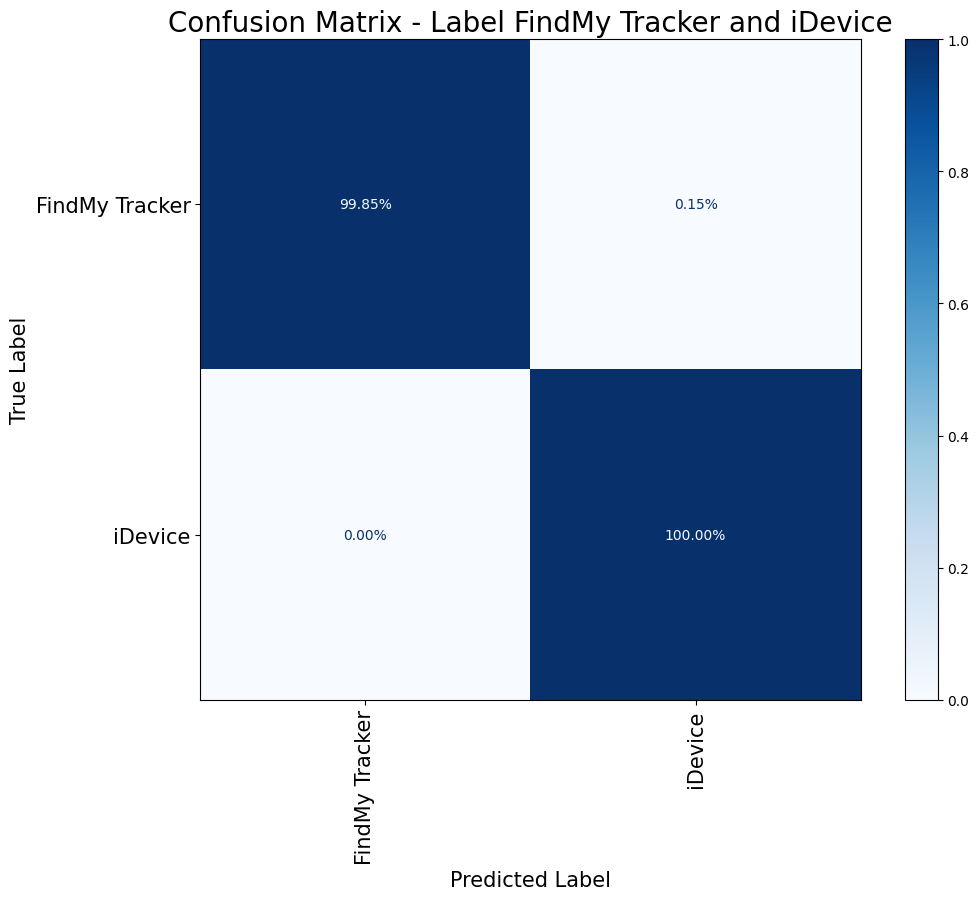

In [15]:
labeledFiles = [r"AirTag\AirTag_(nearby)_labeled_training.csv",
                r"Chipolo\Chipolo_(nearby)_labeled_training.csv",
                r"SkyTag\SkyTag_(nearby)_labeled_training.csv",
                 ]

unlabeledFiles = [#r"AirTag\AirTag_(nearby)_3h.csv",
                  #r"Chipolo\Chipolo_(nearby)_3h.csv",
                  #r"SkyTag\SkyTag_(nearby)_3h.csv"
                   ]

evaluationFiles = [r"AirTag\AirTag_(nearby)_labeled_evaluation.csv",
                   r"Chipolo\Chipolo_(nearby)_labeled_evaluation.csv",
                   r"SkyTag\SkyTag_(nearby)_labeled_evaluation.csv"
                    ]



task_label_FindMyTracker_nearby_auto = nearbyTrackerTaskFactory(BaseConfig=NearbyTrackerConfig, 
                                                         labeledFiles=labeledFiles,
                                                         unlabeledFiles= unlabeledFiles,
                                                         evaluationFiles= evaluationFiles,
                                                         firstDevice=label_FindMy_Tracker,
                                                         secondDevice=label_iDevice,
                                                         flags = flag_label_FindMy_Tracker_and_iDevice)

taskGroup_Labeling_auto.add(task_label_FindMyTracker_nearby_auto)

End of iteration 1, added 133270 new labels.
End of iteration 2, added 24356 new labels.

Classification Report - Label Tile and iDevice
              precision    recall  f1-score   support

        Tile     1.0000    0.9981    0.9990      1033
     iDevice     0.9999    1.0000    0.9999     18619

    accuracy                         0.9999     19652
   macro avg     0.9999    0.9990    0.9995     19652
weighted avg     0.9999    0.9999    0.9999     19652


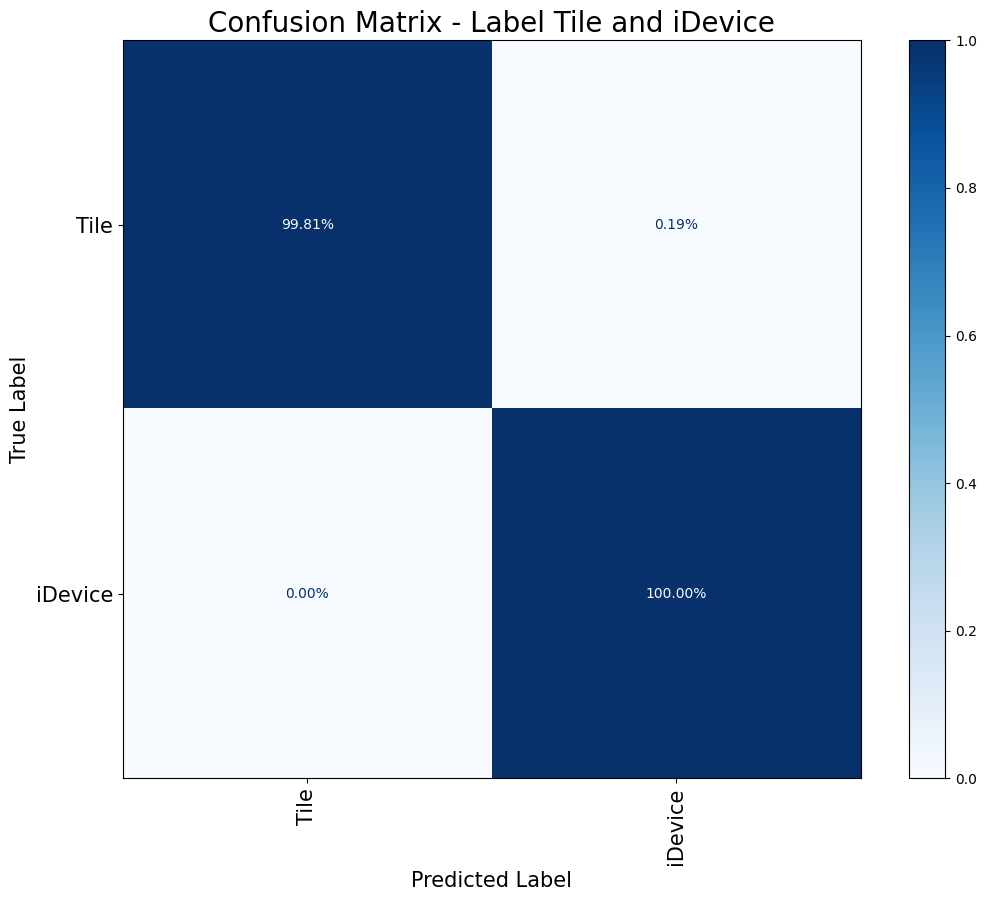

In [16]:
labeledFiles = [r"Tile\Tile_(nearby)_labeled_training.csv",
                ]

unlabeledFiles = [r"Tile\Tile_(nearby)_3h.csv"
                  ]

evaluationFiles = [r"Tile\Tile_(nearby)_labeled_evaluation.csv"
                   ]

task_label_Tile_nearby_auto = nearbyTrackerTaskFactory(BaseConfig=NearbyTrackerConfig,
                                                       labeledFiles=labeledFiles,
                                                       unlabeledFiles= unlabeledFiles,
                                                       evaluationFiles= evaluationFiles,
                                                       firstDevice=label_Tile,
                                                       secondDevice=label_iDevice,
                                                       flags = flag_label_Tile_and_iDevice,
                                                       threshold=0.9
                                                        )

taskGroup_Labeling_auto.add(task_label_Tile_nearby_auto)

End of iteration 1, added 225924 new labels.
End of iteration 2, added 27925 new labels.
End of iteration 3, added 3 new labels.


Classification Report - Label AirPod and iDevice
              precision    recall  f1-score   support

      AirPod     0.9998    1.0000    0.9999      5143
     iDevice     1.0000    0.9997    0.9999      3661

    accuracy                         0.9999      8804
   macro avg     0.9999    0.9999    0.9999      8804
weighted avg     0.9999    0.9999    0.9999      8804


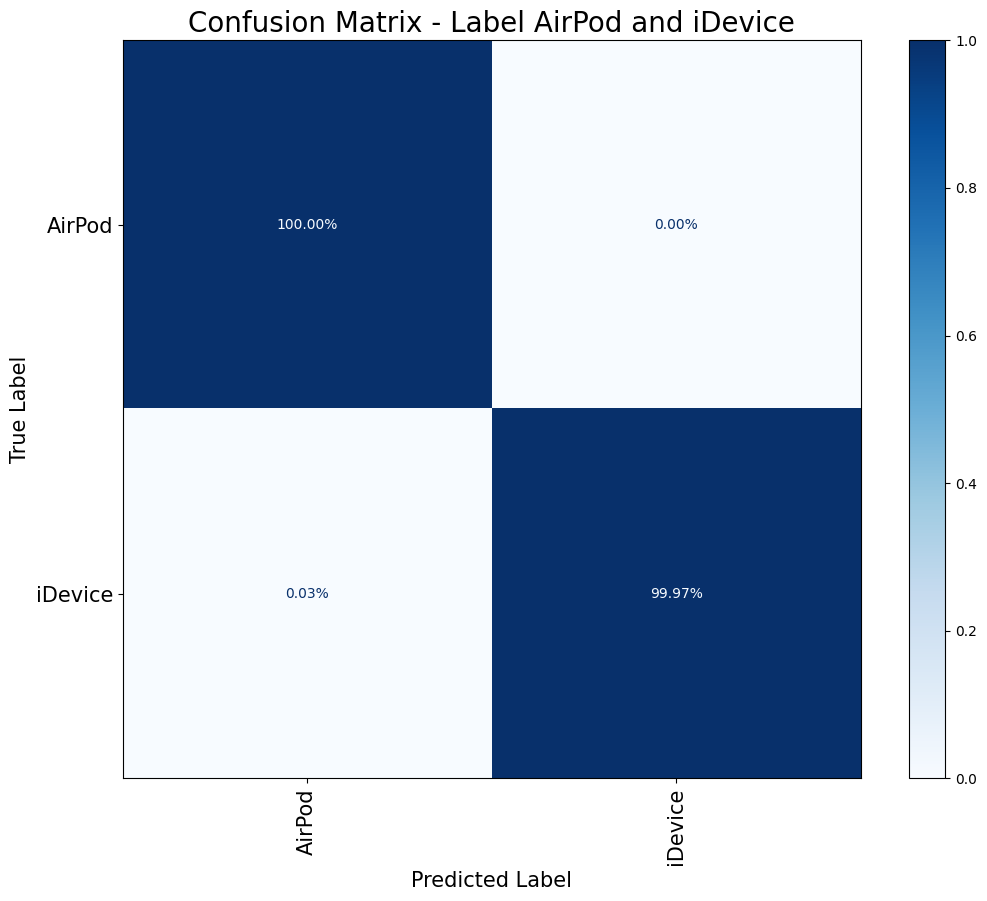

In [17]:
labeledFiles = [r"AirPod\AirPod_(nearby)_labeled_training.csv",
                ]

unlabeledFiles = [r"AirPod\AirPod_(nearby)_3h.csv"
                  ]

evaluationFiles = [r"AirPod\AirPod_(nearby)_labeled_evaluation.csv"
                   ]

task_label_AirPod_nearby_auto = nearbyTrackerTaskFactory(BaseConfig=NearbyTrackerConfig,
                                                         labeledFiles=labeledFiles,
                                                         unlabeledFiles= unlabeledFiles,
                                                         evaluationFiles= evaluationFiles,
                                                         firstDevice=label_AirPod,
                                                         secondDevice=label_iDevice,
                                                         flags = flag_label_AirPod_and_iDevice,
                                                         selection=slice(0, 50),
                                                         threshold=0.8
                                                         )

taskGroup_Labeling_auto.add(task_label_AirPod_nearby_auto)

End of iteration 1, added 112749 new labels.
End of iteration 2, added 3602 new labels.


Classification Report - Label other Device and SmartTag
              precision    recall  f1-score   support

    SmartTag     1.0000    0.9934    0.9967       303
other Device     0.9996    1.0000    0.9998      5413

    accuracy                         0.9997      5716
   macro avg     0.9998    0.9967    0.9983      5716
weighted avg     0.9997    0.9997    0.9996      5716


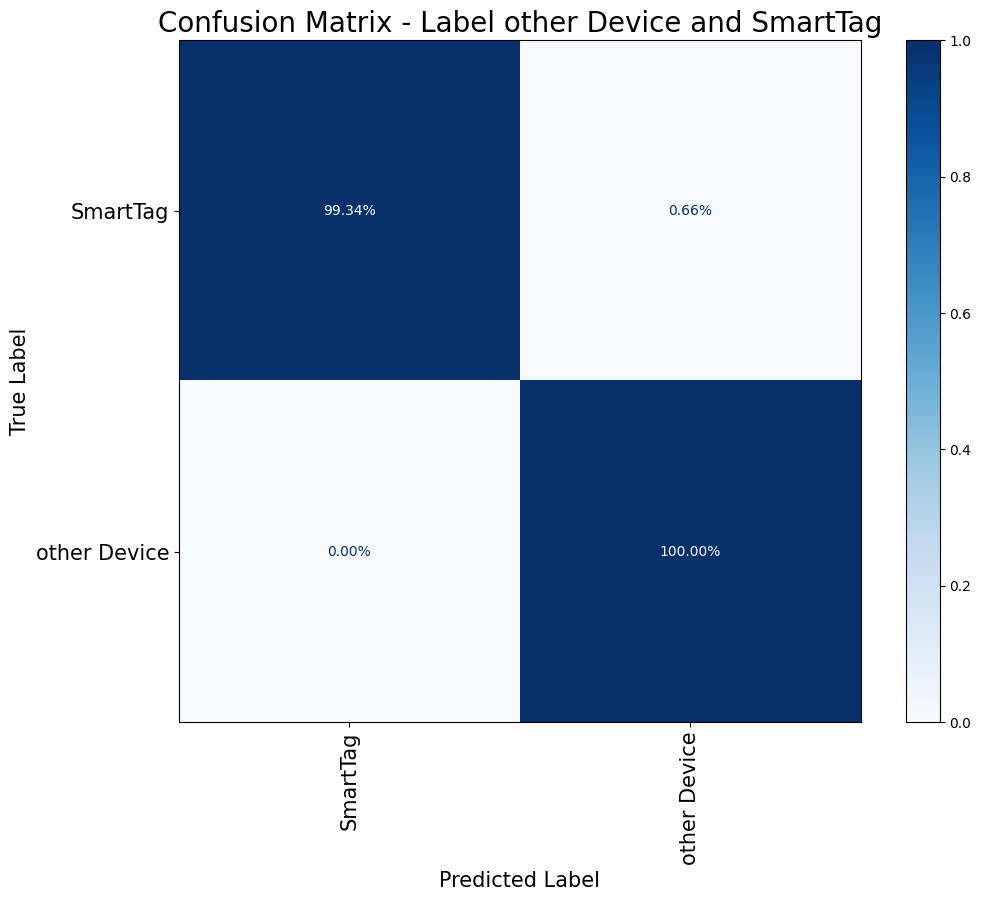

In [18]:
labeledFiles = [r"SmartTag\SmartTag_(nearby)_labeled_training_V1.csv",
                r"SmartTag\SmartTag_(nearby)_labeled_training_V2.csv",
                r"SmartTag\SmartTag_(nearby)_labeled_training_V3.csv"
                ]

unlabeledFiles = [r"SmartTag\SmartTag_(nearby)_3h.csv"
]

evaluationFiles = [r"SmartTag\SmartTag_(nearby)_labeled_evaluation_V1.csv",
                   r"SmartTag\SmartTag_(nearby)_labeled_evaluation_V2.csv",
                   r"SmartTag\SmartTag_(nearby)_labeled_evaluation_V3.csv"
                   ]

task_label_SmartTag_nearby_auto = nearbyTrackerTaskFactory(BaseConfig=NearbyTrackerConfig,
                                                           labeledFiles=labeledFiles,
                                                           unlabeledFiles=unlabeledFiles,
                                                           evaluationFiles=evaluationFiles,
                                                           firstDevice=label_other_Device,
                                                           secondDevice=label_SmartTag,
                                                           flags=flag_label_SmartTag_and_Other, 
                                                           threshold=0.6
                                                         )

taskGroup_Labeling_auto.add(task_label_SmartTag_nearby_auto)

In [19]:
for label in labels_devices:
    task =  Task("Label " + str(label), executor = ex.labeling(label = label), flags = label_flag_lut[label])
    taskGroup_Labeling_manual.add(task)

taskGroup_Labeling.add(taskGroup_Labeling_manual)
taskGroup_Labeling.add(taskGroup_Labeling_auto)

modelingPipeline.add(taskGroup_Labeling)
modelingPipeline.print(priority=True)

Modeling Pipeline
	10 Pre Processing
		10 Select and order columns
		20 Company ID and UUID
			10 Fill Company ID with None
			20 Fill UUID with None
			30 Replace Company IDs
			40 Replace Company UUIDs
		30 MS Data Processing
			10 Fill MS Data with empty String
			20 Length of MS Data
			30 Continuity Type
			40 Drop MS Data Column
		40 Service Data Processing
			10 Fill Service Data with empty String
			20 Length of Service Data
			30 Samsung Type
			40 Drop Service Data Column
		50 Fill Numeric NA with 0
		60 Fill String NA with None
		70 Datetime conversion
		80 Clean PDU
		90 Order DataFrame
		100 Convert object type to string
	20 Dummy Processing
		10 Dummies Channel
		20 Dummies AD Type
		30 Dummies Company
		40 Dummies UUID
		50 Dummies PDU Type
		60 Dummies Continuity Type
		70 Dummies SmartTag Type
	30 Labeling
		10 Labeling auto
			Label FindMy Tracker and iDevice
			Label Tile and iDevice
			Label AirPod and iDevice
			Label other Device and SmartTag
		20 Labeling manual


In [20]:
stateColumn = 'State'

taskGroup_states = TaskGroup("States", priority=40, idempotency=True, flags = flag_states)

task_stateColumn = Task("State Column", executor = ex.instantiateStateColumn(stateColumn = stateColumn), priority=10) 
task_collapseStateColumn = Task("Collapse State Column", executor = ex.collapseStateColumn(stateColumn = stateColumn))

taskGroup_states_iDevices =  TaskGroup("States iDevices", priority=20, idempotency=True, flags = flag_states_iDevices)

task_findMy = Task("Continuity", executor = ex.addStateContinuityType(labelColumn="Label",
                                                                     typeColumn="Continuity Type",
                                                                     types = ['12'],
                                                                     MS_DataColumn_Length= 'Length MS Data',
                                                                     strike = 100,
                                                                     seperator=' ',
                                                                     stateColumn='State',
                                                                     labels=labels_iDevices)
                      )



taskGroup_states_iDevices.addAll([task_findMy])

taskGroup_states_Trackers =  TaskGroup("States Trackers", priority=30, idempotency=True, flags = flag_states_Tracker)

task_lost =  Task("lost", executor= ex.addState(stateColumn=stateColumn, stateLabel="(lost)", labels = labels_trackers), flags = flag_state_lost)
task_nearby =  Task("nearby", executor= ex.addState(stateColumn=stateColumn, stateLabel="(nearby)",  labels = labels_trackers), flags = flag_state_nearby)
task_unpaired = Task("unpaired", executor= ex.addState(stateColumn=stateColumn, stateLabel="(unpaired)", labels = labels_trackers), flags = flag_state_unpaired)

taskGroup_states_Trackers.addAll([task_lost, task_nearby, task_unpaired])

taskGroup_states.addAll([task_stateColumn, task_collapseStateColumn, taskGroup_states_iDevices, taskGroup_states_Trackers])

taskGroup_states.print(priority=True, flags = True)

40 States: States
	10 State Column
	20 States iDevices: States iDevices
		Continuity
	30 States Trackers: States Tracker
		lost: State lost
		nearby: State nearby
		unpaired: State unpaired
	Collapse State Column


In [21]:
flag_dropLabels = Flag("Drop Labels")
flag_drop_label_iDevice = Flag("Drop iDevice", parents=flag_dropLabels)
flag_drop_label_other_Device = Flag("Drop other Device", parents=flag_dropLabels)
flag_drop_label_iDevice_FindMy = Flag("Drop iDevice FindMy", parents=flag_dropLabels)

flags.extend([flag_dropLabels, flag_drop_label_iDevice, flag_drop_label_other_Device, flag_drop_label_iDevice_FindMy])

taskGroup_DropLabels = TaskGroup("Drop Labels", flags = flag_dropLabels, idempotency=True, priority=50)

task_drop_label_iDevice = Task("Drop iDevice", executor= ex.dropLabels(labelColumn="Label", labels = labels_iDevices), flags = flag_drop_label_iDevice)
task_drop_label_otherDevice = Task("Drop other Device", executor= ex.dropLabels(labelColumn="Label", labels = [label_other_Device]), flags = flag_drop_label_other_Device)

online = [i +  ' ' +'FindMy online' for i in labels_iDevices]
offline = [i + ' ' + 'FindMy offline' for i in labels_iDevices]
    
task_drop_label_iDevice_FindMy= Task("Drop iDevice FindMy", executor= ex.dropLabels(labelColumn="Label", labels = online + offline), flags = flag_drop_label_iDevice_FindMy)

taskGroup_DropLabels.addAll([task_drop_label_iDevice, task_drop_label_otherDevice, task_drop_label_iDevice_FindMy])

modelingPipeline.add(taskGroup_DropLabels)

In [22]:
modelingPipeline.add(taskGroup_states)
modelingPipeline.print(priority=True, flags = True)

Modeling Pipeline
	10 Pre Processing: Pre Processing
		10 Select and order columns
		20 Company ID and UUID
			10 Fill Company ID with None
			20 Fill UUID with None
			30 Replace Company IDs
			40 Replace Company UUIDs
		30 MS Data Processing
			10 Fill MS Data with empty String
			20 Length of MS Data
			30 Continuity Type
			40 Drop MS Data Column
		40 Service Data Processing
			10 Fill Service Data with empty String
			20 Length of Service Data
			30 Samsung Type
			40 Drop Service Data Column
		50 Fill Numeric NA with 0
		60 Fill String NA with None
		70 Datetime conversion
		80 Clean PDU
		90 Order DataFrame
		100 Convert object type to string
	20 Dummy Processing: Dummy Processing
		10 Dummies Channel
		20 Dummies AD Type
		30 Dummies Company
		40 Dummies UUID
		50 Dummies PDU Type
		60 Dummies Continuity Type
		70 Dummies SmartTag Type
	30 Labeling: Labeling
		10 Labeling auto: Labeling auto
			Label FindMy Tracker and iDevice: Label FindMy Tracker and iDevice
			Label Tile and

In [23]:
import pickle

with open(picklePath + modelingPipeline.getName() + '.pickle', 'wb') as f:
    pickle.dump(modelingPipeline, f)

In [24]:
flags = list(set(flags))

for flag in flags:
    with open(picklePath  + flag.getName() + '.pickle', 'wb') as f:
        pickle.dump(flag, f)


In [25]:
temp = modelingPipeline.process(data.copy(deep=True), flag = Flag(name = 'Run', parents = [flag_preProcessing, flag_dummy, flag_label_FindMy_Tracker_and_iDevice, flag_state_nearby, flag_drop_label_iDevice, flag_rateModeling]))
temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4492 entries, 0 to 4491
Data columns (total 32 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   Time                                        4492 non-null   datetime64[ns]
 1   Source                                      4492 non-null   string        
 2   Length Packet                               4492 non-null   float64       
 3   Length Header                               4492 non-null   float64       
 4   Length MS Data                              4492 non-null   float64       
 5   Length Service Data                         4492 non-null   float64       
 6   CH 37                                       4492 non-null   float64       
 7   CH 38                                       4492 non-null   float64       
 8   CH 39                                       4492 non-null   float64       
 9   AD Manuf

In [26]:
temp

,Time,Source,Length Packet,Length Header,Length MS Data,Length Service Data,CH 37,CH 38,CH 39,AD Manufacturer Specific,...,PDU ADV_NONCONN_IND,PDU ADV_SCAN_IND,PDU Other,CT 07,CT 12,CT Other,ST 3,ST 5,ST Other,Label
0,2024-04-11 19:18:30,11:71:9c:21:07:06,4.0,1.4,0.0,0.0,0.0,0.0,0.1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,FindMy Tracker (nearby)
1,2024-04-12 01:25:00,37:c8:8a:a3:20:2b,4.0,1.4,0.0,0.0,0.0,0.0,0.1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,FindMy Tracker (nearby)
2,2024-04-11 23:11:50,50:8a:8b:66:c8:a1,4.0,1.4,0.0,0.0,0.0,0.1,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,FindMy Tracker (nearby)
3,2024-04-11 15:19:20,55:34:9e:b3:f8:b5,4.0,1.4,0.0,0.0,0.0,0.1,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,FindMy Tracker (nearby)
4,2024-04-11 18:32:20,59:4b:dd:b7:75:35,4.0,1.4,0.0,0.0,0.0,0.1,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,FindMy Tracker (nearby)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4487,2024-04-11 18:14:10,fa:3c:62:b1:fe:a8,60.0,21.0,48.0,0.0,0.5,0.5,0.5,1.5,...,0.0,0.0,0.0,0.0,1.5,0.0,0.0,0.0,0.0,FindMy Tracker (nearby)
4488,2024-04-11 18:14:20,fa:3c:62:b1:fe:a8,60.0,21.0,48.0,0.0,0.5,0.5,0.5,1.5,...,0.0,0.0,0.0,0.0,1.5,0.0,0.0,0.0,0.0,FindMy Tracker (nearby)
4489,2024-04-11 18:14:30,fa:3c:62:b1:fe:a8,60.0,21.0,48.0,0.0,0.5,0.5,0.5,1.5,...,0.0,0.0,0.0,0.0,1.5,0.0,0.0,0.0,0.0,FindMy Tracker (nearby)
4490,2024-04-11 18:14:40,fa:3c:62:b1:fe:a8,60.0,21.0,48.0,0.0,0.5,0.5,0.5,1.5,...,0.0,0.0,0.0,0.0,1.5,0.0,0.0,0.0,0.0,FindMy Tracker (nearby)


In [27]:
file = r"AirPod\AirPod_(lost).csv"
data = pd.read_csv(dataPath + file, encoding = 'cp1252')

In [28]:
temp = modelingPipeline.process(data.copy(deep=True), flag = Flag(name = 'Run', parents = [flag_preProcessing, flag_dummy, flag_label_iDevice, flag_states_iDevices, flag_drop_label_iDevice_FindMy]))
temp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 693257 entries, 0 to 758102
Data columns (total 33 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   Time                                        693257 non-null  datetime64[ns]
 1   Source                                      693257 non-null  string        
 2   Length Packet                               693257 non-null  int64         
 3   Length Header                               693257 non-null  int64         
 4   Length MS Data                              693257 non-null  int32         
 5   Continuity Type                             693257 non-null  string        
 6   Length Service Data                         693257 non-null  int32         
 7   CH 37                                       693257 non-null  int32         
 8   CH 38                                       693257 non-null  int32         
 9 

In [29]:
temp

,Time,Source,Length Packet,Length Header,Length MS Data,Continuity Type,Length Service Data,CH 37,CH 38,CH 39,...,PDU ADV_NONCONN_IND,PDU ADV_SCAN_IND,PDU Other,CT 07,CT 12,CT Other,ST 3,ST 5,ST Other,Label
0,2024-04-08 19:26:59.144404888,78:ea:09:76:df:94,63,37,216,07,0,0,0,1,...,0,1,0,1,0,0,0,0,0,iDevice
25,2024-04-08 19:26:59.144404888,78:ea:09:76:df:94,63,37,216,07,0,1,0,0,...,0,1,0,1,0,0,0,0,0,iDevice
24,2024-04-08 19:26:59.144404888,78:ea:09:76:df:94,63,37,216,07,0,0,0,1,...,0,1,0,1,0,0,0,0,0,iDevice
23,2024-04-08 19:26:59.144404888,78:ea:09:76:df:94,63,37,216,07,0,0,1,0,...,0,1,0,1,0,0,0,0,0,iDevice
22,2024-04-08 19:26:59.144404888,78:ea:09:76:df:94,63,37,216,07,0,1,0,0,...,0,1,0,1,0,0,0,0,0,iDevice
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
758098,2024-04-09 07:26:59.177983046,59:26:06:5a:44:14,63,37,216,07,0,1,0,0,...,0,1,0,1,0,0,0,0,0,iDevice
758099,2024-04-09 07:26:59.178862095,59:26:06:5a:44:14,63,37,216,07,0,0,1,0,...,0,1,0,1,0,0,0,0,0,iDevice
758100,2024-04-09 07:26:59.359599113,59:26:06:5a:44:14,63,37,216,07,0,0,0,1,...,0,1,0,1,0,0,0,0,0,iDevice
758101,2024-04-09 07:26:59.360476971,59:26:06:5a:44:14,63,37,216,07,0,1,0,0,...,0,1,0,1,0,0,0,0,0,iDevice


In [30]:
file = r"SmartTag\SmartTag_(lost).csv"
data = pd.read_csv(dataPath + file, encoding='cp1252')
temp = modelingPipeline.process(data.copy(deep=True), flag=Flag(name='Run', parents=[flag_preProcessing, flag_dummy,
                                                                                        flag_label_SmartTag]))
temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32829 entries, 0 to 32828
Data columns (total 33 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   Time                                        32829 non-null  datetime64[ns]
 1   Source                                      32829 non-null  string        
 2   Length Packet                               32829 non-null  int64         
 3   Length Header                               32829 non-null  int64         
 4   Length MS Data                              32829 non-null  int32         
 5   Continuity Type                             32829 non-null  string        
 6   Length Service Data                         32829 non-null  int32         
 7   CH 37                                       32829 non-null  int32         
 8   CH 38                                       32829 non-null  int32         
 9   CH 39 

In [31]:
temp

,Time,Source,Length Packet,Length Header,Length MS Data,Continuity Type,Length Service Data,CH 37,CH 38,CH 39,...,PDU ADV_NONCONN_IND,PDU ADV_SCAN_IND,PDU Other,CT 07,CT 12,CT Other,ST 3,ST 5,ST Other,Label
0,2024-04-10 19:47:58.237437963,6d:40:e6:f1:49:01,63,37,0,None,160,1,0,0,...,0,0,0,0,0,0,1,0,0,SmartTag
1,2024-04-10 19:48:00.213016033,6d:40:e6:f1:49:01,63,37,0,None,160,0,1,0,...,0,0,0,0,0,0,1,0,0,SmartTag
2,2024-04-10 19:48:02.189117908,6d:40:e6:f1:49:01,63,37,0,None,160,0,0,1,...,0,0,0,0,0,0,1,0,0,SmartTag
3,2024-04-10 19:48:02.189845085,6d:40:e6:f1:49:01,63,37,0,None,160,1,0,0,...,0,0,0,0,0,0,1,0,0,SmartTag
4,2024-04-10 19:48:04.165843964,6d:40:e6:f1:49:01,63,37,0,None,160,0,1,0,...,0,0,0,0,0,0,1,0,0,SmartTag
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32824,2024-04-11 07:47:51.174439907,58:8d:7e:30:a1:33,63,37,0,None,160,0,1,0,...,0,0,0,0,0,0,1,0,0,SmartTag
32825,2024-04-11 07:47:51.175894022,58:8d:7e:30:a1:33,63,37,0,None,160,0,0,1,...,0,0,0,0,0,0,1,0,0,SmartTag
32826,2024-04-11 07:47:53.151892900,58:8d:7e:30:a1:33,63,37,0,None,160,1,0,0,...,0,0,0,0,0,0,1,0,0,SmartTag
32827,2024-04-11 07:47:53.153347015,58:8d:7e:30:a1:33,63,37,0,None,160,0,1,0,...,0,0,0,0,0,0,1,0,0,SmartTag
